In [28]:
import pandas as pd
import pickle
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# 2 Bias/Variance Trade-off - Application [15pt]

In [2]:
p2_hw = pd.read_pickle("/content/hw2_p2.pkl")
p2_df = pd.DataFrame.from_dict(p2_hw)

In [3]:
p2_df.head()

,x,y
0,0.691790,-2.293679
1,-0.133037,-4.702168
2,-0.712425,-2.237891
3,-0.870378,-1.454281
4,0.993522,-8.117263


In [4]:
p2_df.shape

(100, 2)

1. Split the data in 50/50 ratio for training and testing, fit a polynomial of degree d for d ∈
[1, . . . , 15] to the training set, and calculate and store the training and testing MSE for each
model.

first im defining my bias function that will take in the X input as a parameter and return the mutated input data to the degree of the set parameter

In [5]:
def bias_function(X, degree):
    N = X.shape[0]
    features = [np.ones(N)]
    for d in range(1, degree + 1):
        features.append(X ** d)
    return np.column_stack(features)

here im splitting our data into 50/50 train test splits, and then subsetting our x/y arrays

In [6]:
n = len(p2_df)
p2_train = p2_df.iloc[:n//2].copy()
p2_test = p2_df.iloc[n//2:].copy()

In [7]:
p2_x_train = p2_train["x"]
p2_y_train = p2_train["y"]
p2_x_test = p2_test["x"]
p2_y_test = p2_test["y"]

this loops creates 16 different weight parameter arrays and evaluates each ones training and testing MSE

In [8]:
train_errors, test_errors = [], []
for i in range(1,16):
  X_train = bias_function(p2_x_train, i)
  X_test = bias_function(p2_x_test, i)
  w = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ p2_y_train)

  y_train_pred = X_train @ w
  y_test_pred = X_test @ w

  train_errors.append(np.mean((y_train_pred - p2_y_train) ** 2))
  test_errors.append(np.mean((y_test_pred - p2_y_test) ** 2))

In [9]:
results = pd.DataFrame({
    "degree": range(1, 16),
    "train_mse": train_errors,
    "test_mse": test_errors,

})

results

,degree,train_mse,test_mse
0,1,1.489542,1.239823
1,2,1.452897,1.183177
2,3,0.597542,0.564956
3,4,0.173080,0.226932
4,5,0.172930,0.226948
5,6,0.167272,0.248476
6,7,0.163863,0.231735
7,8,0.156268,0.230528
8,9,0.151773,0.241977
9,10,0.149950,0.237518


2. Repeat this calculation 1000 times, where each time you take a random 50/50 split.

In [10]:
sims = []
n = len(p2_df)

for sim in range(1000):
    shuffled = p2_df.sample(frac=1, random_state=None).reset_index(drop=True)

    p2_train = shuffled.iloc[:n//2].copy()
    p2_test = shuffled.iloc[n//2:].copy()

    p2_x_train, p2_y_train = p2_train["x"].values, p2_train["y"].values
    p2_x_test, p2_y_test = p2_test["x"].values, p2_test["y"].values

    train_errors, test_errors = [], []

    for d in range(1, 16):
        X_train = bias_function(p2_x_train, d)
        X_test = bias_function(p2_x_test, d)

        w = np.linalg.pinv(X_train.T @ X_train) @ (X_train.T @ p2_y_train)

        y_train_pred = X_train @ w
        y_test_pred = X_test @ w

        train_errors.append(np.mean((y_train_pred - p2_y_train) ** 2))
        test_errors.append(np.mean((y_test_pred - p2_y_test) ** 2))

    results = pd.DataFrame({
        "degree": range(1, 16),
        "train_mse": train_errors,
        "test_mse": test_errors,
    })
    sims.append(results)


3. Calculate the mean training error per degree of polynomial (Proxy for Bias).
4. Calculate the standard deviation of the absolute difference between train and test errors, i.e.,
|trainingerror − testingerror|, per degree of polynomial (Proxy for Variance).

In [11]:
all_sims = pd.concat(sims)
all_sims["gap"] = (all_sims["train_mse"] - all_sims["test_mse"]).abs()
summary = all_sims.groupby("degree")[["train_mse", "test_mse", "gap"]].mean()
summary["variance_proxy"] = all_sims.groupby("degree")["gap"].std()
summary


,train_mse,test_mse,gap,variance_proxy
degree,,,,
1,1.320339,1.461354,0.414293,0.281177
2,1.243165,1.530997,0.564037,0.525637
3,0.537379,0.725297,0.228669,0.238054
4,0.185006,0.225485,0.057804,0.041588
5,0.182689,0.239202,0.069743,0.058609
6,0.180081,0.273725,0.103299,0.161541
7,0.166311,0.296993,0.136191,0.249407
8,0.160411,0.359136,0.203633,0.774256
9,0.157299,0.775759,0.620675,3.464514


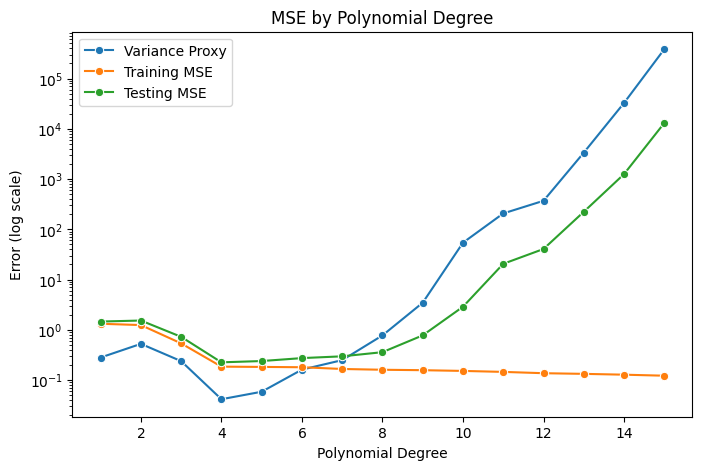

In [12]:
plt.figure(figsize=(8,5))

sns.lineplot(
    data=summary.reset_index(),
    x="degree", y="variance_proxy",
    marker="o", label="Variance Proxy"
)
sns.lineplot(
    data=summary.reset_index(),
    x="degree", y="train_mse",
    marker="o", label="Training MSE"
)
sns.lineplot(
    data=summary.reset_index(),
    x="degree", y="test_mse",
    marker="o", label="Testing MSE"
)

plt.yscale("log")
plt.xlabel("Polynomial Degree")
plt.ylabel("Error (log scale)")
plt.title("MSE by Polynomial Degree")
plt.legend()
plt.show()


# 3 Nonlinear Classification - Application [30pt]

## 3.1 Logistic Regression [15pt]

In [13]:
p3_hw = pd.read_pickle("/content/hw2_p3.pkl")

In [14]:
p3_hw.keys()

dict_keys(['x_train', 'x_test', 'y_train', 'y_test'])

In [15]:
p3_x_train = p3_hw["x_train"].copy()
p3_y_train = p3_hw["y_train"].copy()
p3_x_test = p3_hw["x_test"].copy()
p3_y_test = p3_hw["y_test"].copy()

In [17]:
def bias_function(x, degree):
    x = np.asarray(x)
    n, d = x.shape
    features = [np.ones(n)]

    for deg in range(1, degree+1):
        for comb in itertools.combinations_with_replacement(range(d), deg):
            feat = np.prod(x[:, comb], axis=1)
            features.append(feat)

    return np.column_stack(features)


In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
def train_binary_classifier(X, y, lr=0.1, epochs = 1000):
  N, D = X.shape
  w = np.ones(D)

  for i in range(epochs):
    y_pred = sigmoid(X @ w)
    grad = X.T @ (y_pred - y) / N
    w -= lr * grad
  return w

2. Start with a binary classifier and implement the gradient descent solution for minimizing the
Negative Log Likelihood (NLL) with your proposed basis ϕ

In [20]:
X_train = bias_function(p3_x_train, 4)
X_test = bias_function(p3_x_test, 4)

y_train = (p3_y_train == 0).astype(int)
y_test = (p3_y_test == 0).astype(int)


w = train_binary_classifier(X_train, y_train)

/tmp/ipython-input-3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [21]:
y_pred = sigmoid(X_test @ w)
y_label = (y_pred > 0.5).astype(int)

y_true = y_test.astype(int).ravel()

accuracy = np.mean(y_label == y_true)
accuracy

/tmp/ipython-input-3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


np.float64(0.9733333333333334)

3. How can one extend a binary classifier for multi-class classification? Implement a multi-class
classifier, based on your binary classifier in part 2.

In [22]:
X_train = bias_function(p3_x_train, 4)
X_test = bias_function(p3_x_test, 4)

y1 = (p3_y_train == 0).astype(int)
y2 = (p3_y_train == 1).astype(int)
y3 = (p3_y_train == 2).astype(int)

w1 = train_binary_classifier(X_train, y1)
w2 = train_binary_classifier(X_train, y2)
w3 = train_binary_classifier(X_train, y3)

p1 = sigmoid(X_test @ w1)
p2 = sigmoid(X_test @ w2)
p3 = sigmoid(X_test @ w3)

probs = np.column_stack([p1, p2, p3])

y_pred = np.argmax(probs, axis=1)
y_true = p3_y_test.astype(int).ravel()

accuracy = np.mean(y_pred == y_true)
print("Final Test Accuracy:", accuracy)

Final Test Accuracy: 0.9866666666666667


/tmp/ipython-input-3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


3.2 Kernel Support Vector Machines

In [33]:
def rbf_kernel(X1, X2, sigma=1.0):
    X1_sq = np.sum(X1**2, axis=1)[:, None]
    X2_sq = np.sum(X2**2, axis=1)[None, :]
    sq_dists = X1_sq + X2_sq - 2 * X1 @ X2.T
    return np.exp(-sq_dists / (2 * sigma**2))

def train_svm(X, y, C=1.0):
    y = np.asarray(y, dtype=float)
    if not np.all(np.isin(y, [-1, 1])):
        raise ValueError("Labels must be -1 or +1")

    N = X.shape[0]
    K = rbf_kernel(X, X)

    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(N))
    G = matrix(np.vstack((-np.eye(N), np.eye(N))))
    h = matrix(np.hstack((np.zeros(N), np.ones(N) * C)))
    A = matrix(y.reshape(1, -1).astype("double"))
    b = matrix(np.zeros(1))

    solvers.options["show_progress"] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol["x"]).flatten()
    return alphas

def compute_b(X, y, alphas, C, tol=1e-5):
    K = rbf_kernel(X, X)
    sv = (alphas > tol) & (alphas < C - tol)
    if not np.any(sv):
        return 0.0
    b_values = []
    for i in np.where(sv)[0]:
        s = np.sum(alphas * y * K[:, i])
        b_values.append(y[i] - s)
    return np.mean(b_values)

def predict(X_train, y_train, alphas, b, X_test, raw=False):
    K = rbf_kernel(X_train, X_test)
    decision = np.sum((alphas * y_train)[:, None] * K, axis=0) + b
    return decision if raw else np.sign(decision)



In [38]:
X_train = p3_x_train
X_test = p3_x_test

y1 = np.where(p3_y_train == 0, 1, -1)
y2 = np.where(p3_y_train == 1, 1, -1)
y3 = np.where(p3_y_train == 2, 1, -1)

alphas1 = train_svm(X_train, y1, C=1.0)
b1 = compute_b(X_train, y1, alphas1, C=1.0)

alphas2 = train_svm(X_train, y2, C=1.0)
b2 = compute_b(X_train, y2, alphas2, C=1.0)

alphas3 = train_svm(X_train, y3, C=1.0)
b3 = compute_b(X_train, y3, alphas3, C=1.0)

score1 = predict(X_train, y1, alphas1, b1, X_test,  raw=True)
score2 = predict(X_train, y2, alphas2, b2, X_test,  raw=True)
score3 = predict(X_train, y3, alphas3, b3, X_test,  raw=True)

scores = np.column_stack([score1, score2, score3])
y_pred = np.argmax(scores, axis=1)
y_true = p3_y_test.astype(int).ravel()

accuracy = np.mean(y_pred == y_true)
print("Final SVM Test Accuracy:", accuracy)

Final SVM Test Accuracy: 0.9933333333333333
